
# MTH3302 : Méthodes probabilistes et statistiques pour l'I.A.

Jonathan Jalbert<br/>
Professeur adjoint au Département de mathématiques et de génie industriel<br/>
Polytechnique Montréal<br/>

# Projet : Prédiction des débordements d'égoûts

La description du projet est disponible à l'adresse suivante :
https://www.kaggle.com/t/8b22a09b27944e458e86e7631c0ccfee

Ce calepin Jupyter de base permet de 

1. Charger les données fournies.
2. Effectuer une analyse exploratoire sommaire des données.
3. Développer un modèle simple de prédiction.
4. Générer le fichier de prédictions à téléverser sur Kaggle.

Dans un premier temps, vous devrez récupérer les données sous l'onglet *data* du site Kaggle. Il y a deux fichiers :
- train.csv
- test.csv

Le fichier *train.csv* contient les données sur lesquelles vous pouvez entraîner votre modèle. Il sera ensuite évaluée sur les données de l'ensemble *test.csv* lorsque vous aurez téléversé vos prédictions sur Kaggle. 

### Consignes

- Vous devez constituer une équipe de 3 à 5 personnes.
- Au moins une solution doit être proposée sur Kaggle.
- Utilisez votre numéro d'équipe pour téléverser vos prédictions sur Kaggle.
- Un seul fichier .ipynb par équipe faisant office de rapport et permettant de reproduire vos meilleures prédictions doit être remis.
- Le langage Julia doit être utilisé.
- Votre démarche doit être rigoureusement justifiée (consultez la grille de correction pour vous orienter).

### Quelques conseils

Votre calepin doit permettre de suivre clairement votre raisonnement et de reproduire vos résultats. Garder à l'esprit que vos résultats et votre démarche doivent être reproductibles par une personne à l'extérieur de votre équipe. Le calepin constitue le rapport. Servez vous des cellules de texte pour décrire ce que vous faites.

Je vous encourage fortement à faire une analyse exploratoire de vous données pour développer une meilleure expertise du problème. C'est une étape qui est toujours négligée par les débutants mais qui est essentielle. C'est avec l'analyse exploratoire que vous viendra des idées d'amélioration, par exemple créer de nouvelles variables explicatives.

Vous pouvez utiliser directement tout ce qui se retrouve dans les notes de cours sans explication et toutes les librairies utilisées dans le cours (incluant mes fonctions).

Ce calepin de base contient un modèle très simple de prédiction : on prédit 0 débordement à tous les jours. Ce sera votre travail d'améliorer ces prédictions naïves avec la méthode de votre choix.

Prenez la peine de tout documenter, même les essais infructueux. Ce n'est pas nécessaire de les expliquer en détails, mais c'est important de les mentionner au moins succintement dans la discussion avec une raison possible pour leur échec. De cette façon, une personne qui reprendra votre travail dans le futur ne perdra pas de temps à réessayer une méthode déjà implémentée et infructueuse.

Vous pouvez aussi indiquer dans votre rapport les raisons qui vous font croire pourquoi une méthode à moins bien performée que ce à quoi vous vous attendiez. Vous pouvez également mentionner ce que vous auriez pu tenter si vous aviez eu plus de temps ou plus de données, etc. L'idée est de guider le prochain scientifique qui prendra la relève de votre travail.

Vous êtes limités à deux soumissions par jour par équipe sur Kaggle. Je vous suggère donc de bien tester vos modèles localement et de ne téléverser que vos meilleurs candidats.

In [241]:
using CSV, DataFrames, Gadfly, Statistics, Combinatorics, Dates, GLM, LinearAlgebra, Distributions, MLBase
import StatsBase
import Random

In [242]:
function compute_VIF(structureMatrix::Array{T,2} where T<:Real)

    n = size(structureMatrix,1)

    if all(isapprox.(structureMatrix[:,1], 1))
        m = size(structureMatrix,2)
        p = m-1  # nb de variables explicatives
        S = structureMatrix
    else
        p = size(structureMatrix,2)
        m = p+1
        S = hcat(ones(n), structureMatrix)
    end

    VIF = Float64[]

    for j in 2:m

        y = S[:,j]
        X = S[:, setdiff(1:m, j)]

        β̂ = X\y

        e = y - X*β̂

        SST = sum( (y .- mean(y)).^2)
        SSE = e'e

        R² = 1 - SSE/SST

        push!(VIF, 1/(1-R²))

    end

    return VIF

end


compute_VIF (generic function with 1 method)

## 1. Chargement des données

Assurez vous d'avoir télécharger les données dans le répertoire de ce calepin.

In [243]:
data = CSV.read("train.csv", DataFrame)
first(data,5)

5×13 DataFrame. Omitted printing of 7 columns
│ Row │ Date       │ Duration │ d15min  │ d30min  │ d45min  │ d1h     │
│     │ Date       │ Float64  │ Float64 │ Float64 │ Float64 │ Float64 │
├─────┼────────────┼──────────┼─────────┼─────────┼─────────┼─────────┤
│ 1   │ 2013-06-01 │ 0.0      │ 69.0    │ 100.0   │ 115.0   │ 117.0   │
│ 2   │ 2013-06-02 │ 0.0      │ 27.0    │ 32.0    │ 33.0    │ 35.0    │
│ 3   │ 2013-06-04 │ 0.0      │ 0.0     │ 0.0     │ 0.0     │ 0.0     │
│ 4   │ 2013-06-05 │ 0.0      │ 0.0     │ 0.0     │ 0.0     │ 0.0     │
│ 5   │ 2013-06-06 │ 0.0      │ 5.0     │ 7.0     │ 9.0     │ 12.0    │

In [244]:
test = CSV.read("test.csv", DataFrame);
first(test,5)

5×12 DataFrame. Omitted printing of 5 columns
│ Row │ Date       │ d15min  │ d30min  │ d45min  │ d1h     │ d2h     │ d3h     │
│     │ Date       │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │
├─────┼────────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┤
│ 1   │ 2013-06-03 │ 0.0     │ 0.0     │ 0.0     │ 0.0     │ 0.0     │ 0.0     │
│ 2   │ 2013-06-07 │ 5.0     │ 9.0     │ 12.0    │ 16.0    │ 26.0    │ 31.0    │
│ 3   │ 2013-06-12 │ 9.0     │ 13.0    │ 16.0    │ 16.0    │ 23.0    │ 36.0    │
│ 4   │ 2013-06-13 │ 2.0     │ 2.0     │ 2.0     │ 2.0     │ 2.0     │ 2.0     │
│ 5   │ 2013-06-23 │ 0.0     │ 0.0     │ 4.0     │ 4.0     │ 9.0     │ 28.0    │

## 2. Analyse exploratoire sommaire

C'est une analyse exploratoire sommaire. Je vous encourage formtement à poursuivre cette analyse.



#### 2.1 Surverse vs accumulation de pluie sur 2h

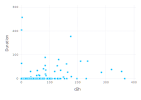

In [245]:
plot(data, x = :d2h, y = :Duration)

#### 2.2 Surverse vs accumulation de pluie sur 2h et 4h

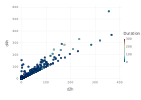

In [246]:
plot(data, x = :d2h, y = :d4h, color = :Duration)

#### 2.3 Surverse vs accumulation de pluie sur 2h et 4h

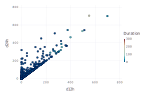

In [247]:
plot(data, x = :d12h, y = :d24h, color = :Duration)

D24H

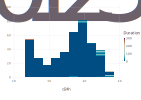

In [248]:
# TODO: Analyse exploratoire
plot(data, x=:d24h, color=:Duration, Geom.histogram(bincount=10), Scale.x_log10)

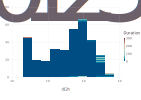

In [249]:
plot(data, x=:d12h, color=:Duration, Geom.histogram(bincount=10), Scale.x_log10)

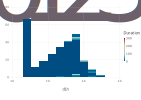

In [250]:
plot(data, x=:d1h, color=:Duration, Geom.histogram(bincount=10), Scale.x_log10)

In [251]:
df_grosDeb = filter(row -> row[:Duration] > 150, data)
df_dates=filter(row -> row[:Date] > DateTime(2015, 09, 01), data)
df_deb = filter(row -> row[:Duration] > 0, df_dates)

25×13 DataFrame. Omitted printing of 7 columns
│ Row │ Date       │ Duration │ d15min  │ d30min  │ d45min  │ d1h     │
│     │ Date       │ Float64  │ Float64 │ Float64 │ Float64 │ Float64 │
├─────┼────────────┼──────────┼─────────┼─────────┼─────────┼─────────┤
│ 1   │ 2015-09-02 │ 64.0     │ 0.0     │ 0.0     │ 0.0     │ 0.0     │
│ 2   │ 2015-09-03 │ 257.0    │ 2.0     │ 2.0     │ 2.0     │ 2.0     │
│ 3   │ 2015-09-04 │ 204.0    │ 0.0     │ 0.0     │ 0.0     │ 0.0     │
│ 4   │ 2015-09-12 │ 30.0     │ 6.0     │ 11.0    │ 15.0    │ 19.0    │
│ 5   │ 2016-07-09 │ 13.0     │ 17.0    │ 33.0    │ 45.0    │ 54.0    │
│ 6   │ 2016-07-14 │ 34.0     │ 41.0    │ 56.0    │ 56.0    │ 56.0    │
│ 7   │ 2016-08-14 │ 54.0     │ 31.0    │ 61.0    │ 75.0    │ 85.0    │
│ 8   │ 2016-08-16 │ 30.0     │ 79.0    │ 144.0   │ 197.0   │ 220.0   │
│ 9   │ 2016-10-21 │ 19.0     │ 16.0    │ 29.0    │ 43.0    │ 50.0    │
│ 10  │ 2017-07-08 │ 8.5      │ 128.0   │ 149.0   │ 152.0   │ 162.0   │
⋮
│ 15  │ 2018-07-25 │ 73.1333  │ 89.0    │ 137.0   │ 162.0   │ 169.0   │
│ 16  │ 2018-08-01 │ 6.93333  │ 23.0    │ 30.0    │ 33.0    │ 33.0    │
│ 17  │ 2018-09-02 │ 89.0167  │ 32.0    │ 57.0    │ 69.0    │ 69.0    │
│ 18  │ 2018-09-21 │ 6.73333  │ 68.0    │ 103.0   │ 112.0   │ 144.0   │
│ 19  │ 2019-07-11 │ 34.95    │ 61.0    │ 104.0   │ 133.0   │ 139.0   │
│ 20  │ 2019-08-08 │ 35.9833  │ 24.0    │ 38.0    │ 50.0    │ 59.0    │
│ 21  │ 2019-08-09 │ 15.0333  │ 51.0    │ 56.0    │ 59.0    │ 59.0    │
│ 22  │ 2019-09-02 │ 41.2667  │ 15.0    │ 27.0    │ 33.0    │ 46.0    │
│ 23  │ 2019-10-17 │ 177.083  │ 33.0    │ 58.0    │ 80.0    │ 99.0    │
│ 24  │ 2019-10-27 │ 61.7167  │ 33.0    │ 63.0    │ 88.0    │ 102.0   │
│ 25  │ 2019-10-31 │ 73.3333  │ 47.0    │ 89.0    │ 122.0   │ 146.0   │

In [252]:
show(df_deb, allcols = true)

25×13 DataFrame
│ Row │ Date       │ Duration │ d15min  │ d30min  │ d45min  │ d1h     │
│     │ Date       │ Float64  │ Float64 │ Float64 │ Float64 │ Float64 │
├─────┼────────────┼──────────┼─────────┼─────────┼─────────┼─────────┤
│ 1   │ 2015-09-02 │ 64.0     │ 0.0     │ 0.0     │ 0.0     │ 0.0     │
│ 2   │ 2015-09-03 │ 257.0    │ 2.0     │ 2.0     │ 2.0     │ 2.0     │
│ 3   │ 2015-09-04 │ 204.0    │ 0.0     │ 0.0     │ 0.0     │ 0.0     │
│ 4   │ 2015-09-12 │ 30.0     │ 6.0     │ 11.0    │ 15.0    │ 19.0    │
│ 5   │ 2016-07-09 │ 13.0     │ 17.0    │ 33.0    │ 45.0    │ 54.0    │
│ 6   │ 2016-07-14 │ 34.0     │ 41.0    │ 56.0    │ 56.0    │ 56.0    │
│ 7   │ 2016-08-14 │ 54.0     │ 31.0    │ 61.0    │ 75.0    │ 85.0    │
│ 8   │ 2016-08-16 │ 30.0     │ 79.0    │ 144.0   │ 197.0   │ 220.0   │
│ 9   │ 2016-10-21 │ 19.0     │ 16.0    │ 29.0    │ 43.0    │ 50.0    │
│ 10  │ 2017-07-08 │ 8.5      │ 128.0   │ 149.0   │ 152.0   │ 162.0   │
⋮
│ 15  │ 2018-07-25 │ 73.1333  │ 89.0    │ 137.

#### 2.4 Variables crees

##### Intensite de pluie

In [253]:
function addRainIntensity(file::DataFrame)
    fileSize = size(file, 1)
    d = Array{Int64}(undef,fileSize)
    for i=1:length(file[:, :Date])
        intensity = floor(file[i, :d24h] / 24)
        d[i] = intensity
    end
    file[:, :RAIN_INTENSITY] = d
end

addRainIntensity(data)
addRainIntensity(test)

101-element Array{Int64,1}:
  5
  4
 14
  1
  4
  0
  0
  4
  0
  4
  7
  3
  0
  ⋮
  0
  1
  0
 12
  0
  2
  2
 22
  2
  0
  0
  2

###### MOIS

On classifie chaque jour selon le mois dont il appartient. Nous pensons que le mois de l'année influence le montant de pluie qu'il y aura.

In [254]:
function addMonth(file::DataFrame)
    fileSize = size(file, 1)
    d = Array{Int64}(undef,fileSize)
    for i=1:length(file[:, :Date])
        date = file[i, :Date];
        month = Dates.month(date)
        if month == 5
            d[i] = 0
        elseif month == 6
            d[i] = 1
        elseif month == 7
            d[i] = 2
        elseif month == 8
            d[i] = 3
        elseif month == 9
            d[i] = 4
        elseif month == 10
            d[i] = 5
        end
    end
    file[:, :Month] = d
end

addMonth(data)
addMonth(test)

101-element Array{Int64,1}:
 1
 1
 1
 1
 1
 0
 0
 2
 2
 2
 0
 0
 0
 ⋮
 3
 3
 3
 4
 4
 4
 4
 5
 5
 5
 5
 5

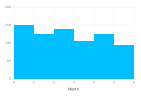

In [255]:
# TODO: Analyse exploratoire
plot(data, x=:Month, Geom.histogram(bincount=6))

### DID_RAIN

In [256]:
function adddidRain(file::DataFrame)
    fileSize = size(file, 1)
    d = Array{Int64}(undef,fileSize)
    for i=1:length(file[:, :d24h])
        accumulation = file[i, :d24h];
        print(accumulation)
        if accumulation > 0
            d[i] = 1
        else
            d[i] = 0
        end
    end
    file[:, :DID_RAIN] = d
end

adddidRain(test)
adddidRain(data)

123.0114.0346.038.0119.02.02.098.021.0113.0187.090.04.090.0237.03.0155.0392.0334.056.0289.013.02.010.042.0315.032.010.08.044.08.07.0173.021.0711.0163.073.054.025.07.0121.046.0241.02.0108.0500.02.0162.0116.0116.014.066.077.0163.013.02.087.05.0236.022.024.03.012.0210.04.011.034.014.026.02.04.0156.041.010.0128.04.050.073.055.083.0113.057.0110.053.0229.027.027.02.0105.023.029.02.0293.023.048.053.0549.053.02.02.061.0117.0240.00.00.045.0102.061.00.0312.02.00.0102.0102.00.00.00.00.0119.065.078.044.00.0174.0176.02.05.0183.00.00.06.072.062.00.03.03.00.0198.0388.0186.00.00.00.038.042.070.041.014.014.00.00.00.030.030.00.089.089.062.00.00.00.098.021.00.00.00.00.00.00.0113.00.00.092.092.083.05.0127.00.02.04.08.010.02.00.00.084.084.0183.02.02.00.090.00.00.02.02.02.0190.047.048.050.023.053.00.00.02.02.03.0155.00.09.012.064.00.00.07.0100.0100.02.00.00.00.00.00.00.06.083.094.00.00.00.07.092.085.00.00.00.040.04.00.00.00.00.00.00.00.00.00.010.00.00.00.00.042.00.0283.00.00.00.044.00.00.00.02.02.00.00.069.

740-element Array{Int64,1}:
 1
 1
 0
 0
 1
 1
 1
 0
 1
 1
 0
 1
 1
 ⋮
 0
 0
 1
 1
 1
 0
 0
 1
 1
 1
 0
 1

In [257]:
adddidRain(test)

123.0114.0346.038.0119.02.02.098.021.0113.0187.090.04.090.0237.03.0155.0392.0334.056.0289.013.02.010.042.0315.032.010.08.044.08.07.0173.021.0711.0163.073.054.025.07.0121.046.0241.02.0108.0500.02.0162.0116.0116.014.066.077.0163.013.02.087.05.0236.022.024.03.012.0210.04.011.034.014.026.02.04.0156.041.010.0128.04.050.073.055.083.0113.057.0110.053.0229.027.027.02.0105.023.029.02.0293.023.048.053.0549.053.02.02.061.0

101-element Array{Int64,1}:
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 ⋮
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1

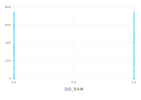

In [258]:
plot(data, x=:DID_RAIN)

### MAX_ACCUMULATION

In [259]:
function addMaxAccumulationDay(file::DataFrame)
    fileSize = size(file, 1)
    d = Array{Int64}(undef,fileSize)
    for i=1:length(file[:d24h])
        max_accumulation = max(file[i, [:d15min, :d30min, :d45min, :d1h, :d2h, :d3h, :d4h, :d6h, :d8h, :d12h, :d24h]]...)
        d[i] = max_accumulation
    end
   
    file[:MAX_ACCUMULATION] = d
end

addMaxAccumulationDay(data)
addMaxAccumulationDay(test)

101-element Array{Int64,1}:
 123
 114
 346
  38
 119
   2
   2
  98
  21
 113
 187
  90
   4
   ⋮
  23
  29
   2
 293
  23
  48
  53
 549
  53
   2
   2
  61

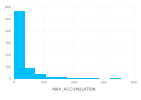

In [260]:
plot(data, x=:MAX_ACCUMULATION, Geom.histogram(bincount=10))

Suit possiblement un exponentielle?

## 3. Nettoyage des données

In [261]:
dropmissing(data)

740×17 DataFrame. Omitted printing of 11 columns
│ Row │ Date       │ Duration │ d15min  │ d30min  │ d45min  │ d1h     │
│     │ Date       │ Float64  │ Float64 │ Float64 │ Float64 │ Float64 │
├─────┼────────────┼──────────┼─────────┼─────────┼─────────┼─────────┤
│ 1   │ 2013-06-01 │ 0.0      │ 69.0    │ 100.0   │ 115.0   │ 117.0   │
│ 2   │ 2013-06-02 │ 0.0      │ 27.0    │ 32.0    │ 33.0    │ 35.0    │
│ 3   │ 2013-06-04 │ 0.0      │ 0.0     │ 0.0     │ 0.0     │ 0.0     │
│ 4   │ 2013-06-05 │ 0.0      │ 0.0     │ 0.0     │ 0.0     │ 0.0     │
│ 5   │ 2013-06-06 │ 0.0      │ 5.0     │ 7.0     │ 9.0     │ 12.0    │
│ 6   │ 2013-06-08 │ 0.0      │ 14.0    │ 20.0    │ 24.0    │ 29.0    │
│ 7   │ 2013-06-09 │ 0.0      │ 0.0     │ 0.0     │ 0.0     │ 0.0     │
│ 8   │ 2013-06-10 │ 0.0      │ 0.0     │ 0.0     │ 0.0     │ 0.0     │
│ 9   │ 2013-06-11 │ 13.0     │ 18.0    │ 32.0    │ 43.0    │ 54.0    │
│ 10  │ 2013-06-14 │ 0.0      │ 0.0     │ 0.0     │ 0.0     │ 0.0     │
⋮
│ 730 │ 2019-10-21 │ 0.0      │ 0.0     │ 0.0     │ 0.0     │ 0.0     │
│ 731 │ 2019-10-22 │ 0.0      │ 14.0    │ 28.0    │ 39.0    │ 53.0    │
│ 732 │ 2019-10-23 │ 0.0      │ 12.0    │ 25.0    │ 36.0    │ 50.0    │
│ 733 │ 2019-10-24 │ 0.0      │ 0.0     │ 0.0     │ 0.0     │ 0.0     │
│ 734 │ 2019-10-25 │ 0.0      │ 0.0     │ 0.0     │ 0.0     │ 0.0     │
│ 735 │ 2019-10-26 │ 0.0      │ 0.0     │ 0.0     │ 0.0     │ 0.0     │
│ 736 │ 2019-10-27 │ 61.7167  │ 33.0    │ 63.0    │ 88.0    │ 102.0   │
│ 737 │ 2019-10-28 │ 0.0      │ 2.0     │ 2.0     │ 2.0     │ 2.0     │
│ 738 │ 2019-10-29 │ 0.0      │ 0.0     │ 0.0     │ 0.0     │ 0.0     │
│ 739 │ 2019-10-30 │ 0.0      │ 0.0     │ 0.0     │ 0.0     │ 0.0     │
│ 740 │ 2019-10-31 │ 73.3333  │ 47.0    │ 89.0    │ 122.0   │ 146.0   │

## 4. Préparation

#### 4.1 Verification de multicolinearite

In [262]:
variables = names(data[3:16])

14-element Array{String,1}:
 "d15min"
 "d30min"
 "d45min"
 "d1h"
 "d2h"
 "d3h"
 "d4h"
 "d6h"
 "d8h"
 "d12h"
 "d24h"
 "RAIN_INTENSITY"
 "Month"
 "DID_RAIN"

In [263]:
df = DataFrame(Variable = String[], VIF = Float64[])

for variable in combinations(variables,1)
    y = data[:, variable[] ]
    ȳ = mean(y)
    X = hcat(ones(n), convert(Matrix{Float64}, data[:, setdiff(variables, variable)]) )
    β̂ = X\y
    ŷ = X*β̂
    e = y-ŷ
    SSE = e'*e
    SST = sum( (y .- ȳ).^2 )
    R² = 1 - SSE/SST
    VIF = 1/(1-R²)
    push!(df, [variable[], VIF])
end

df

14×2 DataFrame
│ Row │ Variable       │ VIF     │
│     │ String         │ Float64 │
├─────┼────────────────┼─────────┤
│ 1   │ d15min         │ 38.2019 │
│ 2   │ d30min         │ 139.738 │
│ 3   │ d45min         │ 262.969 │
│ 4   │ d1h            │ 173.788 │
│ 5   │ d2h            │ 105.418 │
│ 6   │ d3h            │ 128.79  │
│ 7   │ d4h            │ 135.378 │
│ 8   │ d6h            │ 62.2073 │
│ 9   │ d8h            │ 30.5201 │
│ 10  │ d12h           │ 25.9284 │
│ 11  │ d24h           │ 357.118 │
│ 12  │ RAIN_INTENSITY │ 344.555 │
│ 13  │ Month          │ 1.01913 │
│ 14  │ DID_RAIN       │ 2.19187 │

### Selection des variables explicatives par comparaison de R2 

In [264]:
y = data[:, :Duration]
ȳ = mean(y)
SST = sum( (y .- ȳ).^2 )


df = DataFrame(Variable = Vector{String}[], R² = Float64[])

for variable in combinations(variables)
    
    p = length(variable)
    
    X = hcat(ones(n), convert(Matrix{Float64},data[:, variable]))
    
    
    β̂ = X\y
    ŷ = X*β̂

    e = y-ŷ

    SSE = e'*e

    R²aj =  1 - SSE/SST * (n-1)/(n-p)
    
    push!(df, [variable, R²aj])
#     println(variable)
    
end

sort(df, :R², rev=true)


16383×2 DataFrame. Omitted printing of 2 columns
│ Row   │ │       │ ├───────┼
│ 1     │ │ 2     │ │ 3     │ │ 4     │ │ 5     │ │ 6     │ │ 7     │ │ 8     │ │ 9     │ │ 10    │ 
⋮
│ 16373 │ │ 16374 │ │ 16375 │ │ 16376 │ │ 16377 │ │ 16378 │ │ 16379 │ │ 16380 │ │ 16381 │ │ 16382 │ │ 16383 │

### Analyse en composantes principales

Dans le but d'eliminer la multicolinearite, nous effectuons une PCA

X = convert(Array{Float64}, data[:, 3:end])

y = data.Duration

Z = standardize(X)
standardize!(y)

Z

F = svd(Z)
U = F.U
V = F.V
γ = F.S
w = round.(V[:,1], digits=2)

println("La première composante principale est composée de : ")
println("\t  T₁ = $(w[1]) Z₁ + $(w[2]) Z₂ + $(w[3]) Z₃ + $(w[4]) Z₄ + $(w[5]) Z₅")

v = cumsum(γ.^2) / sum(γ.^2)

Il faut utiliser 4 composantes principales afin d'expliquer 96% de la variance.

T = Z*V
η̂ = T\y
β̂ = V*η̂

X_test = convert(Array{Float64}, test[:, 2:15])
Z_test = standardize(X_test)
F = svd(Z)
U = F.U
V = F.V
γ = F.S
w = round.(V[:,1], digits=2)
v = cumsum(γ.^2) / sum(γ.^2)
T = Z*V
η̂ = T\y
β̂ = V*η̂
ŷ = Z_test*β̂

## Approche

1. Faire une classification pour determiner quelle date a eu une duree positive de deversement. Le resultat de la classification sera soit 0, s'il n'y a aucun deversement, ou 1 s'il y a eu lieu.

    1.1 Pour les dates ou il y a eu un deversement, faire une regression lineaire pour predire (pas tres accurate)
    
    1.2 Pour les dates ou aucun deversement, mettre la duree a 0.

In [265]:
# classification Bayésienne

#étape 1 : séparation en ensemble de validation et  d'entrainement
Random.seed!(3302)
train_id = sample(1:nrow(data), round(Int, 0.8*length(data[:,1])), replace=false, ordered=true)
valid_id = setdiff(1:nrow(data), train_id)

train = data[train_id, :]
valid = data[valid_id, :]
print(length(train_id))

592

Parler du nombre peu élevé de débordements par rapport au non débordement, qui complexifie la prédiction

In [266]:
#étape 2 : Loiprédictive

#loi à priori : tout les jours, il y a une chance uniforme d'y avoir undébordement
α, β = (1,1)

# nombre de jour sans débordement dans l'ensemble d'entraînement
n₀ = length(filter(row -> row[:Duration] == 0, train)[:, 1])

# nombre de debordement dans l'ensemble d'entraînement
n₁ = length(filter(row -> row[:Duration] > 0, train)[:, 1])
print(n₁)
# taille de l'échantillon d'entraînement
n = n₀ + n₁


# Probabilité qu'il y ai un débordement le nouveau jour
p₁ = (α + n₁)/(α + β + n)

# Probabilité qu'il n'y ai pas de débordement le nouveau jour
p₀ = (β + n₀)/(α + β + n)

23

0.9595959595959596

In [267]:
#étape 3 : introduction d'une variable explicative, on va prendre d1h
# encours , on a vu que des variable explicative discrètes. ici, on a des variables explicatives cntinues, donc on va les transformer en variable binaire avec un test de seuil tel que déterminé plus bas
# ça me semble une bonne approche, dans la mesure où une combinaison de seuil sur les différentes variable va probablement nous permettre d'obtenir une classification potable

#variable explicative : v1 = 1 si v1:d1h > seuil_d1h
#                            0 sinon

#recherche du seuil tq si row:d1h >= seuil, p(row:debordement >0) >0.5
df_1h = sort(train, [:d1h], rev =true)
seuil_d1h = df_1h[4, :d1h]
i=4
i_positif = length(filter(row -> row[:Duration]>0, df_1h[1:4, :])[:,1])
while (i_positif*2 >= i)
    i+=1
    if (df_1h[i,:Duration]>0)
        seuil_d1h =df_1h[i, :d1h]
        i_positif += 1
    end
end

println(seuil_d1h)
println(i_positif)
println(i)

#loi à priori
α₀₁, β₀₁ = (1,1)
α₁₁, β₁₁ = (1,1)

n₀₁ = length(filter(row -> row[:Duration]==0 &&row[:d1h]>=seuil_d1h, df_1h[1:i, :])[:,1])
n₁₁ = length(filter(row -> row[:Duration]>0 &&row[:d1h]>=seuil_d1h, df_1h[1:i, :])[:,1])

println(n₀₁, " jours sans débordement on connu des épisodes de d1h >", seuil_d1h)
println(n₁₁, " jours avec débordement on connu des épisodes de d1h >", seuil_d1h)



99.0
9
19
7 jours sans débordement on connu des épisodes de d1h >99.0
9 jours avec débordement on connu des épisodes de d1h >99.0


In [268]:
#étape 4 : probabilité prédictives

# proba qu'il y a un débordement le jour donné sachant qu'il a plu au moins autant que le seuil sur 1h
p₀ = (β + n₀)/(α + β + n) * (α₀₁ + n₀₁)/(α₀₁ + β₀₁ + n₀)
p₁ = (α + n₁)/(α + β + n ) * (α₁₁ + n₁₁)/(α₁₁ + β₁₁ +n₁)

# constante de normalisation
c = p₀ + p₁
p₀ = p₀/c
p₁ = p₁/c
println( " sachant qu'il a plu au dessus du seuil, p₁=", p₁)


# proba qu'il y a un débordement le jour donné sachant qu'il a plu moins que le seuil sur 1h
p₀ = (β + n₀)/(α + β + n) * (β₀₁ + n₀ - n₀₁)/(α₀₁ + β₀₁ + n₀)
p₁ = (α + n₁)/(α + β + n ) * (β₁₁ + n₁ - n₁₁)/(α₁₁ + β₁₁ + n₁)

# constante de normalisation
c = p₀ + p₁
p₀ = p₀/c
p₁ = p₁/c
println( " sachant qu'il a plu en dessous du seuil, p₁=", p₁)


 sachant qu'il a plu au dessus du seuil, p₁=0.5458891013384322
 sachant qu'il a plu en dessous du seuil, p₁=0.024982043700346734


In [269]:
#étape 5: validation
Z = Int64[]

Ẑ = Int64[]

for row in eachrow(valid)
    
    if row[:Duration]>0
        push!(Z,1)
    else
        push!(Z,0)
    end
    
    if row[:d1h]>seuil_d1h
        push!(Ẑ,1)
    else
        push!(Ẑ,0)
    end
end

for row in eachrow(valid)
    
    
 
end


r = roc(Z, Ẑ)

ROCNums{Int64}
  p = 6
  n = 142
  tp = 2
  tn = 141
  fp = 1
  fn = 4


In [270]:
for r in eachrow(valid)
    print(r)
end

DataFrameRow
│ Row │ Date       │ Duration │ d15min  │ d30min  │ d45min  │ d1h     │ d2h     │ d3h     │ d4h     │ d6h     │ d8h     │ d12h    │ d24h    │ RAIN_INTENSITY │ Month │ DID_RAIN │ MAX_ACCUMULATION │
│     │ Date       │ Float64  │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Int64          │ Int64 │ Int64    │ Int64            │
├─────┼────────────┼──────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼────────────────┼───────┼──────────┼──────────────────┤
│ 1   │ 2013-06-08 │ 0.0      │ 14.0    │ 20.0    │ 24.0    │ 29.0    │ 43.0    │ 50.0    │ 56.0    │ 64.0    │ 69.0    │ 72.0    │ 102.0   │ 4              │ 1     │ 1        │ 102              │DataFrameRow
│ Row │ Date       │ Duration │ d15min  │ d30min  │ d45min  │ d1h     │ d2h     │ d3h     │ d4h     │ d6h     │ d8h     │ d12h    │ d24h    │ RAIN_INTENSITY │ Month │ DID_RAIN │ MAX_ACCUM

│ 10  │ 2014-07-19 │ 0.0      │ 0.0     │ 0.0     │ 0.0     │ 0.0     │ 0.0     │ 0.0     │ 0.0     │ 0.0     │ 0.0     │ 0.0     │ 0.0     │ 0              │ 2     │ 0        │ 0                │DataFrameRow
│ Row │ Date       │ Duration │ d15min  │ d30min  │ d45min  │ d1h     │ d2h     │ d3h     │ d4h     │ d6h     │ d8h     │ d12h    │ d24h    │ RAIN_INTENSITY │ Month │ DID_RAIN │ MAX_ACCUMULATION │
│     │ Date       │ Float64  │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Int64          │ Int64 │ Int64    │ Int64            │
├─────┼────────────┼──────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼────────────────┼───────┼──────────┼──────────────────┤
│ 11  │ 2014-07-21 │ 0.0      │ 0.0     │ 0.0     │ 0.0     │ 0.0     │ 0.0     │ 0.0     │ 0.0     │ 0.0     │ 0.0     │ 0.0     │ 0.0     │ 0              │ 2     │ 0        │ 0                │Data

├─────┼────────────┼──────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼────────────────┼───────┼──────────┼──────────────────┤
│ 19  │ 2015-09-06 │ 0.0      │ 0.0     │ 0.0     │ 0.0     │ 0.0     │ 0.0     │ 0.0     │ 0.0     │ 0.0     │ 0.0     │ 0.0     │ 3.0     │ 0              │ 4     │ 1        │ 3                │DataFrameRow
│ Row │ Date       │ Duration │ d15min  │ d30min  │ d45min  │ d1h     │ d2h     │ d3h     │ d4h     │ d6h     │ d8h     │ d12h    │ d24h    │ RAIN_INTENSITY │ Month │ DID_RAIN │ MAX_ACCUMULATION │
│     │ Date       │ Float64  │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Int64          │ Int64 │ Int64    │ Int64            │
├─────┼────────────┼──────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼────────────────┼───────┼──────────┼──────────────────┤
│ 2

├─────┼────────────┼──────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼────────────────┼───────┼──────────┼──────────────────┤
│ 28  │ 2016-05-21 │ 0.0      │ 0.0     │ 0.0     │ 0.0     │ 0.0     │ 0.0     │ 0.0     │ 0.0     │ 0.0     │ 0.0     │ 0.0     │ 0.0     │ 0              │ 0     │ 0        │ 0                │DataFrameRow
│ Row │ Date       │ Duration │ d15min  │ d30min  │ d45min  │ d1h     │ d2h     │ d3h     │ d4h     │ d6h     │ d8h     │ d12h    │ d24h    │ RAIN_INTENSITY │ Month │ DID_RAIN │ MAX_ACCUMULATION │
│     │ Date       │ Float64  │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Int64          │ Int64 │ Int64    │ Int64            │
├─────┼────────────┼──────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼────────────────┼───────┼──────────┼──────────────────┤
│ 2

│ Row │ Date       │ Duration │ d15min  │ d30min  │ d45min  │ d1h     │ d2h     │ d3h     │ d4h     │ d6h     │ d8h     │ d12h    │ d24h    │ RAIN_INTENSITY │ Month │ DID_RAIN │ MAX_ACCUMULATION │
│     │ Date       │ Float64  │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Int64          │ Int64 │ Int64    │ Int64            │
├─────┼────────────┼──────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼────────────────┼───────┼──────────┼──────────────────┤
│ 37  │ 2016-07-09 │ 13.0     │ 17.0    │ 33.0    │ 45.0    │ 54.0    │ 64.0    │ 72.0    │ 95.0    │ 95.0    │ 116.0   │ 159.0   │ 159.0   │ 6              │ 2     │ 1        │ 159              │DataFrameRow
│ Row │ Date       │ Duration │ d15min  │ d30min  │ d45min  │ d1h     │ d2h     │ d3h     │ d4h     │ d6h     │ d8h     │ d12h    │ d24h    │ RAIN_INTENSITY │ Month │ DID_RAIN │ MAX_ACCUMULATION │
│  

├─────┼────────────┼──────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼────────────────┼───────┼──────────┼──────────────────┤
│ 45  │ 2016-08-27 │ 0.0      │ 0.0     │ 0.0     │ 0.0     │ 0.0     │ 0.0     │ 0.0     │ 0.0     │ 0.0     │ 0.0     │ 0.0     │ 0.0     │ 0              │ 3     │ 0        │ 0                │DataFrameRow
│ Row │ Date       │ Duration │ d15min  │ d30min  │ d45min  │ d1h     │ d2h     │ d3h     │ d4h     │ d6h     │ d8h     │ d12h    │ d24h    │ RAIN_INTENSITY │ Month │ DID_RAIN │ MAX_ACCUMULATION │
│     │ Date       │ Float64  │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Int64          │ Int64 │ Int64    │ Int64            │
├─────┼────────────┼──────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼────────────────┼───────┼──────────┼──────────────────┤
│ 4

├─────┼────────────┼──────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼────────────────┼───────┼──────────┼──────────────────┤
│ 54  │ 2016-10-11 │ 0.0      │ 0.0     │ 0.0     │ 0.0     │ 0.0     │ 0.0     │ 0.0     │ 0.0     │ 0.0     │ 0.0     │ 0.0     │ 0.0     │ 0              │ 5     │ 0        │ 0                │DataFrameRow
│ Row │ Date       │ Duration │ d15min  │ d30min  │ d45min  │ d1h     │ d2h     │ d3h     │ d4h     │ d6h     │ d8h     │ d12h    │ d24h    │ RAIN_INTENSITY │ Month │ DID_RAIN │ MAX_ACCUMULATION │
│     │ Date       │ Float64  │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Int64          │ Int64 │ Int64    │ Int64            │
├─────┼────────────┼──────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼────────────────┼───────┼──────────┼──────────────────┤
│ 5

├─────┼────────────┼──────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼────────────────┼───────┼──────────┼──────────────────┤
│ 65  │ 2017-07-08 │ 8.5      │ 128.0   │ 149.0   │ 152.0   │ 162.0   │ 177.0   │ 177.0   │ 177.0   │ 177.0   │ 185.0   │ 207.0   │ 207.0   │ 8              │ 2     │ 1        │ 207              │DataFrameRow
│ Row │ Date       │ Duration │ d15min  │ d30min  │ d45min  │ d1h     │ d2h     │ d3h     │ d4h     │ d6h     │ d8h     │ d12h    │ d24h    │ RAIN_INTENSITY │ Month │ DID_RAIN │ MAX_ACCUMULATION │
│     │ Date       │ Float64  │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Int64          │ Int64 │ Int64    │ Int64            │
├─────┼────────────┼──────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼────────────────┼───────┼──────────┼──────────────────┤
│ 6

│ 76  │ 2017-09-26 │ 0.0      │ 0.0     │ 0.0     │ 0.0     │ 0.0     │ 0.0     │ 0.0     │ 0.0     │ 0.0     │ 0.0     │ 0.0     │ 0.0     │ 0              │ 4     │ 0        │ 0                │DataFrameRow
│ Row │ Date       │ Duration │ d15min  │ d30min  │ d45min  │ d1h     │ d2h     │ d3h     │ d4h     │ d6h     │ d8h     │ d12h    │ d24h    │ RAIN_INTENSITY │ Month │ DID_RAIN │ MAX_ACCUMULATION │
│     │ Date       │ Float64  │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Int64          │ Int64 │ Int64    │ Int64            │
├─────┼────────────┼──────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼────────────────┼───────┼──────────┼──────────────────┤
│ 77  │ 2017-10-02 │ 0.0      │ 0.0     │ 0.0     │ 0.0     │ 0.0     │ 0.0     │ 0.0     │ 0.0     │ 0.0     │ 0.0     │ 0.0     │ 0.0     │ 0              │ 5     │ 0        │ 0                │Data

├─────┼────────────┼──────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼────────────────┼───────┼──────────┼──────────────────┤
│ 85  │ 2018-05-31 │ 0.0      │ 0.0     │ 0.0     │ 0.0     │ 0.0     │ 0.0     │ 0.0     │ 0.0     │ 0.0     │ 0.0     │ 0.0     │ 0.0     │ 0              │ 0     │ 0        │ 0                │DataFrameRow
│ Row │ Date       │ Duration │ d15min  │ d30min  │ d45min  │ d1h     │ d2h     │ d3h     │ d4h     │ d6h     │ d8h     │ d12h    │ d24h    │ RAIN_INTENSITY │ Month │ DID_RAIN │ MAX_ACCUMULATION │
│     │ Date       │ Float64  │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Int64          │ Int64 │ Int64    │ Int64            │
├─────┼────────────┼──────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼────────────────┼───────┼──────────┼──────────────────┤
│ 8

├─────┼────────────┼──────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼────────────────┼───────┼──────────┼──────────────────┤
│ 95  │ 2018-08-03 │ 0.0      │ 0.0     │ 0.0     │ 0.0     │ 0.0     │ 0.0     │ 0.0     │ 0.0     │ 0.0     │ 0.0     │ 0.0     │ 3.0     │ 0              │ 3     │ 1        │ 3                │DataFrameRow
│ Row │ Date       │ Duration │ d15min  │ d30min  │ d45min  │ d1h     │ d2h     │ d3h     │ d4h     │ d6h     │ d8h     │ d12h    │ d24h    │ RAIN_INTENSITY │ Month │ DID_RAIN │ MAX_ACCUMULATION │
│     │ Date       │ Float64  │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Int64          │ Int64 │ Int64    │ Int64            │
├─────┼────────────┼──────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼────────────────┼───────┼──────────┼──────────────────┤
│ 9

│ Row │ Date       │ Duration │ d15min  │ d30min  │ d45min  │ d1h     │ d2h     │ d3h     │ d4h     │ d6h     │ d8h     │ d12h    │ d24h    │ RAIN_INTENSITY │ Month │ DID_RAIN │ MAX_ACCUMULATION │
│     │ Date       │ Float64  │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Int64          │ Int64 │ Int64    │ Int64            │
├─────┼────────────┼──────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼────────────────┼───────┼──────────┼──────────────────┤
│ 104 │ 2018-10-10 │ 0.0      │ 12.0    │ 18.0    │ 21.0    │ 24.0    │ 39.0    │ 39.0    │ 39.0    │ 45.0    │ 45.0    │ 45.0    │ 51.0    │ 2              │ 5     │ 1        │ 51               │DataFrameRow
│ Row │ Date       │ Duration │ d15min  │ d30min  │ d45min  │ d1h     │ d2h     │ d3h     │ d4h     │ d6h     │ d8h     │ d12h    │ d24h    │ RAIN_INTENSITY │ Month │ DID_RAIN │ MAX_ACCUMULATION │
│  

│ Row │ Date       │ Duration │ d15min  │ d30min  │ d45min  │ d1h     │ d2h     │ d3h     │ d4h     │ d6h     │ d8h     │ d12h    │ d24h    │ RAIN_INTENSITY │ Month │ DID_RAIN │ MAX_ACCUMULATION │
│     │ Date       │ Float64  │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Int64          │ Int64 │ Int64    │ Int64            │
├─────┼────────────┼──────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼────────────────┼───────┼──────────┼──────────────────┤
│ 113 │ 2019-05-22 │ 0.0      │ 2.0     │ 2.0     │ 2.0     │ 2.0     │ 2.0     │ 2.0     │ 2.0     │ 2.0     │ 2.0     │ 2.0     │ 4.0     │ 0              │ 0     │ 1        │ 4                │DataFrameRow
│ Row │ Date       │ Duration │ d15min  │ d30min  │ d45min  │ d1h     │ d2h     │ d3h     │ d4h     │ d6h     │ d8h     │ d12h    │ d24h    │ RAIN_INTENSITY │ Month │ DID_RAIN │ MAX_ACCUMULATION │
│  

├─────┼────────────┼──────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼────────────────┼───────┼──────────┼──────────────────┤
│ 121 │ 2019-06-24 │ 0.0      │ 0.0     │ 0.0     │ 0.0     │ 0.0     │ 0.0     │ 0.0     │ 0.0     │ 0.0     │ 0.0     │ 0.0     │ 0.0     │ 0              │ 1     │ 0        │ 0                │DataFrameRow
│ Row │ Date       │ Duration │ d15min  │ d30min  │ d45min  │ d1h     │ d2h     │ d3h     │ d4h     │ d6h     │ d8h     │ d12h    │ d24h    │ RAIN_INTENSITY │ Month │ DID_RAIN │ MAX_ACCUMULATION │
│     │ Date       │ Float64  │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Int64          │ Int64 │ Int64    │ Int64            │
├─────┼────────────┼──────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼────────────────┼───────┼──────────┼──────────────────┤
│ 1

├─────┼────────────┼──────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼────────────────┼───────┼──────────┼──────────────────┤
│ 130 │ 2019-07-10 │ 0.0      │ 0.0     │ 0.0     │ 0.0     │ 0.0     │ 0.0     │ 0.0     │ 0.0     │ 0.0     │ 0.0     │ 0.0     │ 0.0     │ 0              │ 2     │ 0        │ 0                │DataFrameRow
│ Row │ Date       │ Duration │ d15min  │ d30min  │ d45min  │ d1h     │ d2h     │ d3h     │ d4h     │ d6h     │ d8h     │ d12h    │ d24h    │ RAIN_INTENSITY │ Month │ DID_RAIN │ MAX_ACCUMULATION │
│     │ Date       │ Float64  │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Int64          │ Int64 │ Int64    │ Int64            │
├─────┼────────────┼──────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼────────────────┼───────┼──────────┼──────────────────┤
│ 1

├─────┼────────────┼──────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼────────────────┼───────┼──────────┼──────────────────┤
│ 139 │ 2019-08-29 │ 0.0      │ 0.0     │ 0.0     │ 0.0     │ 0.0     │ 0.0     │ 0.0     │ 0.0     │ 11.0    │ 45.0    │ 137.0   │ 159.0   │ 6              │ 3     │ 1        │ 159              │DataFrameRow
│ Row │ Date       │ Duration │ d15min  │ d30min  │ d45min  │ d1h     │ d2h     │ d3h     │ d4h     │ d6h     │ d8h     │ d12h    │ d24h    │ RAIN_INTENSITY │ Month │ DID_RAIN │ MAX_ACCUMULATION │
│     │ Date       │ Float64  │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Int64          │ Int64 │ Int64    │ Int64            │
├─────┼────────────┼──────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼────────────────┼───────┼──────────┼──────────────────┤
│ 1

├─────┼────────────┼──────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼────────────────┼───────┼──────────┼──────────────────┤
│ 148 │ 2019-10-27 │ 61.7167  │ 33.0    │ 63.0    │ 88.0    │ 102.0   │ 160.0   │ 201.0   │ 240.0   │ 298.0   │ 306.0   │ 328.0   │ 353.0   │ 14             │ 5     │ 1        │ 353              │

In [271]:
Z_test = Float64[]

for row in eachrow(test)
    if row[:d1h]>seuil_d1h
        push!(Z_test,1)
    else
        push!(Z_test,0)
    end
end

In [272]:
Z_test
test.Duration = Z_test

101-element Array{Float64,1}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 1.0
 0.0
 0.0
 0.0
 0.0

#### 5.2 Regression ridge

Nous choisissons d'utiliser une regression ridge, qui est une generalisation...

In [273]:
# Nous prenons en compte seulement les dates qui ont eu une surverse
# train = filter(row -> (row.Duration > 0), data)

In [274]:
ty = StatsBase.fit(StatsBase.ZScoreTransform, data.Duration, dims=1)
y = StatsBase.transform(ty, data.Duration)
tx = StatsBase.fit(StatsBase.ZScoreTransform, Matrix{Float64}(data[:,3:end]), dims=1)
X = StatsBase.transform(tx, Matrix{Float64}(data[:,3:end]));

In [275]:
n = length(y)
m = size(X,2)

λ = .2

β̂ᵣ = (X'X + λ*I)\X'y

s² = (y'y - β̂ᵣ'*(X'X + λ*I)*β̂ᵣ)/n

Σ = Symmetric(inv(X'X+λ*I))

println("β̂ᵣ = ", β̂ᵣ)
println("s² = ", s²)

β̂ᵣ = [0.13806177781930032, -0.24042812742407632, 0.20272003526737306, -0.6384338705896593, 0.6075661379147171, -0.03793042138519968, 0.017020658905316163, 0.20242945768242346, -0.01801572927042485, 0.026152868374942188, -0.8748947917154364, 1.7514274829312113, 0.07910501019616072, 0.07194207149217938, -0.8748947917122092]
s² = 0.8641599020865817


In [276]:
f₁(σ²::Real) = MvNormal(β̂ᵣ,σ²*Σ)
f₂(β::Vector{<:Real}) = InverseGamma((n+m)/2, .5(y-X*β)'*(y-X*β) + .5*λ*β'β)

f₂ (generic function with 1 method)

In [277]:
niter = 1000

β = Array{Float64}(undef, m, niter)
σ² = Array{Float64}(undef, niter)

β[:,1] = zeros(m)
σ²[1] = .05

for j in 2:niter
    β[:,j] = rand(f₁(σ²[j-1]))
    σ²[j] = rand(f₂(β[:,j]))
end

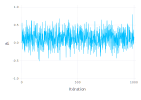

In [278]:
fig = plot(y=β[1,:], Geom.line, Guide.xlabel("Itération"), Guide.ylabel("β₁"))

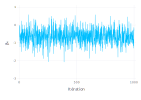

In [279]:
fig = plot(y=β[4,:], Geom.line, Guide.xlabel("Itération"), Guide.ylabel("β₄"))

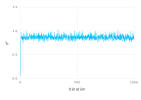

In [280]:
fig = plot(y=σ², Geom.line, Guide.xlabel("Itération"), Guide.ylabel("σ²"))

In [281]:
β = β[:, 101:1000]
σ² = σ²[101:1000];

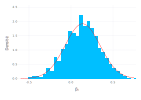

In [282]:
f = LocationScale(β̂ᵣ[1], sqrt(s²*Σ[1,1]), TDist(n))

fig = plot(Guide.xlabel("β₁"), Guide.ylabel("Densité"), Coord.cartesian(xmin=-.6, xmax=.75),
    layer(x->pdf(f, x), -.6, .75, Theme(default_color=colorant"red")),
    layer(x=β[1,:], Geom.histogram(density=true, bincount=30))
)

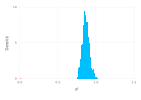

In [283]:
f = InverseGamma(n/2,n*s²/2)

fig = plot(Guide.xlabel("σ²"), Guide.ylabel("Densité"),
    layer(x->pdf(f, x), 0, .02, Theme(default_color=colorant"red")),
    layer(x=σ², Geom.histogram(density=true, bincount=30))
)

In [284]:
df2 = DataFrame(λ = Float64[], mse = Float64[], rmse = Float64[])

# Transformation des variables explicatives de l'échantillon de validation
# X_valid = StatsBase.transform(tx, Matrix{Float64}(test[:,3:7]));

for λ in 0:.01:6
    # Estimation des coefficients de régression ridge
    β̂ = (X'X + λ*I)\X'y
    # Prédictions retransformées dans l'espaces originales
    ŷ = StatsBase.reconstruct(ty, X*β̂)
    # Calcul du mse
    mse = StatsBase.msd(ŷ, data.Duration)
    # Calcul du rmse
    rmse = StatsBase.rmsd(ŷ, data.Duration)
    
    push!(df2, [λ, mse, rmse])
end

In [285]:
sort!(df2)

601×3 DataFrame
│ Row │ λ       │ mse     │ rmse    │
│     │ Float64 │ Float64 │ Float64 │
├─────┼─────────┼─────────┼─────────┤
│ 1   │ 0.0     │ 217.832 │ 14.7591 │
│ 2   │ 0.01    │ 217.832 │ 14.7591 │
│ 3   │ 0.02    │ 217.833 │ 14.7592 │
│ 4   │ 0.03    │ 217.833 │ 14.7592 │
│ 5   │ 0.04    │ 217.834 │ 14.7592 │
│ 6   │ 0.05    │ 217.836 │ 14.7593 │
│ 7   │ 0.06    │ 217.837 │ 14.7593 │
│ 8   │ 0.07    │ 217.839 │ 14.7594 │
│ 9   │ 0.08    │ 217.841 │ 14.7594 │
│ 10  │ 0.09    │ 217.843 │ 14.7595 │
⋮
│ 591 │ 5.9     │ 220.202 │ 14.8392 │
│ 592 │ 5.91    │ 220.204 │ 14.8393 │
│ 593 │ 5.92    │ 220.206 │ 14.8393 │
│ 594 │ 5.93    │ 220.208 │ 14.8394 │
│ 595 │ 5.94    │ 220.21  │ 14.8395 │
│ 596 │ 5.95    │ 220.212 │ 14.8395 │
│ 597 │ 5.96    │ 220.214 │ 14.8396 │
│ 598 │ 5.97    │ 220.215 │ 14.8397 │
│ 599 │ 5.98    │ 220.217 │ 14.8397 │
│ 600 │ 5.99    │ 220.219 │ 14.8398 │
│ 601 │ 6.0     │ 220.221 │ 14.8399 │

In [286]:
X_test = StatsBase.transform(tx, Matrix{Float64}(test[:,2:16]));
λ = 0.01
β̂ = (X'X + λ*I)\X'y
ŷ = StatsBase.reconstruct(ty, X_test*β̂)

101-element Array{Float64,1}:
  2.1513290174029627
  1.3587069171742128
  6.56429466966772
 -2.376522547236547
 -1.595163560423409
  0.4896428368797425
  0.48933451334713807
  3.092325067277578
 -3.413309721710502
 -1.9343356768814415
 11.78207319501706
 -3.7589964056586798
  0.03887710830480673
  ⋮
 -4.201395519692934
  1.9538794896138616
  2.830221481870752
  8.00231645494403
 -1.2116059639876804
  6.168181438903936
  4.172141978152142
 28.016437041506162
 10.030897389519374
  4.175889457308912
  4.304843459455461
  6.537474650658461

In [287]:
for i in 1:size(test, 1)
    if (test[i, :Duration] == 1)
        test[i, :Duration] = ŷ[i]
    end
end

In [288]:
test.Duration

101-element Array{Float64,1}:
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  ⋮
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
 28.016437041506162
  0.0
  0.0
  0.0
  0.0

In [289]:
prediction = select(test, :Date, :Duration)

101×2 DataFrame
│ Row │ Date       │ Duration │
│     │ Date       │ Float64  │
├─────┼────────────┼──────────┤
│ 1   │ 2013-06-03 │ 0.0      │
│ 2   │ 2013-06-07 │ 0.0      │
│ 3   │ 2013-06-12 │ 0.0      │
│ 4   │ 2013-06-13 │ 0.0      │
│ 5   │ 2013-06-23 │ 0.0      │
│ 6   │ 2014-05-23 │ 0.0      │
│ 7   │ 2014-05-29 │ 0.0      │
│ 8   │ 2014-07-14 │ 0.0      │
│ 9   │ 2014-07-16 │ 0.0      │
│ 10  │ 2014-07-24 │ 0.0      │
⋮
│ 91  │ 2019-08-22 │ 0.0      │
│ 92  │ 2019-08-26 │ 0.0      │
│ 93  │ 2019-09-03 │ 0.0      │
│ 94  │ 2019-09-10 │ 0.0      │
│ 95  │ 2019-09-23 │ 0.0      │
│ 96  │ 2019-09-24 │ 0.0      │
│ 97  │ 2019-10-01 │ 28.0164  │
│ 98  │ 2019-10-04 │ 0.0      │
│ 99  │ 2019-10-06 │ 0.0      │
│ 100 │ 2019-10-15 │ 0.0      │
│ 101 │ 2019-10-16 │ 0.0      │

In [290]:
CSV.write("benchmark_predictions.csv",prediction)

"benchmark_predictions.csv"